# Setting Up Working Environment

## Sync to GitHub

In [1]:
from getpass import getpass
import os

user = getpass('github user')
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf sigmoid
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-sigmoid.git sigmoid

github user··········
github password··········
Cloning into 'sigmoid'...
remote: Enumerating objects: 135, done.
remote: Total 135 (delta 0), reused 0 (delta 0), pack-reused 135
Receiving objects: 100% (135/135), 24.89 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (46/46), done.


## Sync to Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Install Dependencies and CUDA

In [3]:
%pylab inline
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import time
import random
import copy

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


## Import Tools to Perform Supervised Learning on KMNIST

In [0]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from sigmoid.KMNISTLearning import *

# Define Model Classes
Each model class should include a `forward` method.

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
class mLeNet5(nn.Module):
  def __init__(self):
     super(mLeNet5, self).__init__()
     self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
     self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
     self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c5 = nn.Linear(16*5*5, 1150)
     self.f6 = nn.Linear(1150, 256)
     self.output = nn.Linear(256, 10)
     self.act = nn.ReLU()
     self.dp = nn.Dropout(0.5)

  def forward(self, x):
     x = self.act(self.c1(x))
     x = self.act(self.s2(x))
     x = self.act(self.c3(x))
     x = self.act(self.s4(x))
     x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
     x = self.act(self.c5(x))
     x = self.dp(x)
     x = self.act(self.f6(x))
     x = self.dp(x)
     return self.output(x)

In [0]:
class AlexNetMod(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Import Data as `torch.Tensor`

In [8]:
# Import Data
path="sigmoid/data/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

# Size Check
print("Train Data:", X.size())
print("Test Data:", X_test.size())
print("Train Labels:", y.size())

Train Data: torch.Size([60000, 28, 28])
Test Data: torch.Size([10000, 28, 28])
Train Labels: torch.Size([60000])


# Model Training, Saving and Loading

## Example 1: LeNet5 with no Augmentation

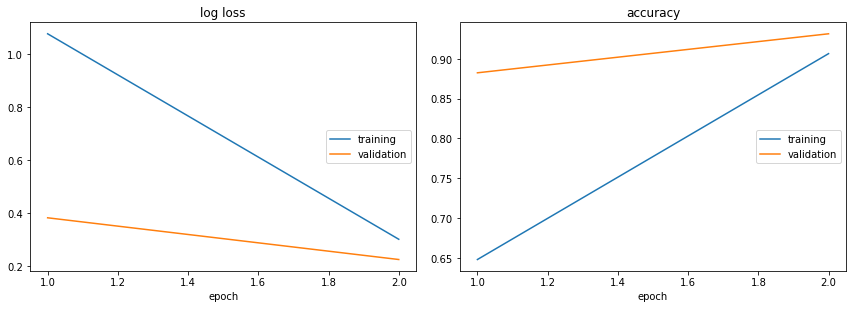

log loss:
training   (min:    0.302, max:    1.078, cur:    0.302)
validation (min:    0.226, max:    0.383, cur:    0.226)

accuracy:
training   (min:    0.648, max:    0.907, cur:    0.907)
validation (min:    0.882, max:    0.931, cur:    0.931)

 {'log loss': 0.30240184701813594, 'accuracy': 0.9065555555555556, 'val_log loss': 0.22598050181070964, 'val_accuracy': 0.9315, '_i': 2, 'time': 24.538856029510498}
Saving model under: /content/gdrive/My Drive/Models/lenet5_test_931.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Test Set Predictions: [3 9 3 ... 9 8 3]


In [10]:
# Lenet5 no augmentation
# Model Name
MODEL_NAME = "lenet5_test"

# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 2
patience=5
early_stop_tol = 0.000
n_folds=0
weight_decay=0

# Define/Load Model, Optimiser and Loss Function
model = LeNet5()
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()

# Create Supervised Learning Object
learning = SupervisedLearning(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device=device,
                 transform=False, 
                 seed=42, n_epochs=n_epochs,
                 val_ratio=0.1, n_splits=n_folds+1, 
                 early_stop = False,
                 patience = patience,
                 tol = early_stop_tol)

# Train model with validation
learning.train_wrapper(train_full=False)
print("\n", learning.logs)

# Saving model
path = F"/content/gdrive/My Drive/Models/"
full_save(path, MODEL_NAME, model, optimiser, loss_function, early_stop_tol, learning.logs["_i"], lr, momentum, weight_decay, n_folds, learning.transform, learning.logs["val_accuracy"], learning.logs["val_log loss"], train_time=learning.logs["time"])


# Train full model


# Save full model


# Evaluate and save test dataset prediction
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)
y_preds, sub = evaluate(X_test/255., model, norm_mean, norm_std, 
                                       test_batch_size=test_batch_size, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"PREDICTION_FILE_NAME_HERE.csv")
print("\nTest Set Predictions:",y_preds)

## Example 2: K-Fold validation LeNet5 Dropout with no augmentation

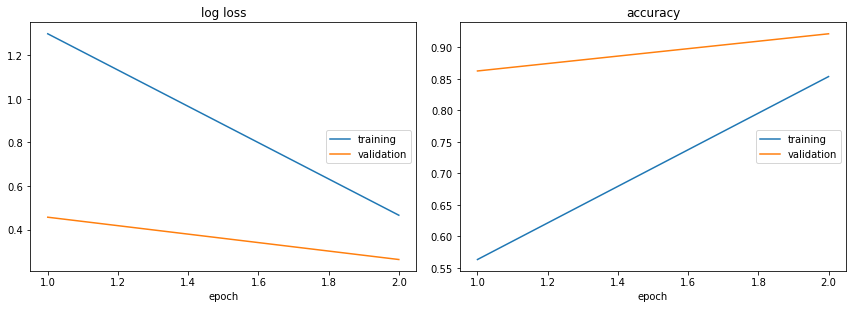

log loss:
training   (min:    0.467, max:    1.298, cur:    0.467)
validation (min:    0.263, max:    0.457, cur:    0.263)

accuracy:
training   (min:    0.563, max:    0.854, cur:    0.854)
validation (min:    0.863, max:    0.922, cur:    0.922)
The  2  fold finished.
 
Result:
----------------------------
Average validation loss for  3  folds is  0.26744270222981775
Average validation accuracy for  3  folds is  0.91745
Average train loss for  3  folds is  0.4703748411019643
Average train accuracy for  3  folds is  0.8525666666666667

 {'log loss': 0.46657115314006803, 'accuracy': 0.85365, 'val_log loss': 0.2634975120544434, 'val_accuracy': 0.92155, '_i': 2, 'time': 22.131464958190918}

 [0.2634975120544434, 0.92155, 0.46657115314006803, 0.85365]
Saving model under: /content/gdrive/My Drive/Models/mlenet5_test_921.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type mLeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Test Set Predictions: [3 9 3 ... 9 8 6]


In [11]:
# Lenet5 Dropout no augmentation, K-Fold
# Model Name
MODEL_NAME = "mlenet5_test"

# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 2
patience=5
early_stop_tol = 0.000
n_folds=3
weight_decay=0

# Define/Load Model, Optimiser and Loss Function
model = mLeNet5().to(device)
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()


# Create Supervised Learning Object
learning = KFoldValidation(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device=device, 
                 confusion_matrix=True, 
                 transform=False, 
                 seed=42, n_epochs=n_epochs,
                 n_folds=n_folds, 
                 early_stop = False,
                 patience = patience,
                 tol = early_stop_tol
                     )


# Train K-Fold validation model
learning.cross_validation()
print("\n", learning.logs)
print("\n", learning.result)

# Saving model
path = F"/content/gdrive/My Drive/Models/"
full_save(path, MODEL_NAME, model, optimiser, loss_function, early_stop_tol, learning.logs["_i"], lr, momentum, weight_decay, n_folds, learning.transform, learning.logs["val_accuracy"], learning.logs["val_log loss"], train_time=learning.logs["time"])


# Evaluate and save test dataset prediction
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)
y_preds, sub = evaluate(X_test/255., model, norm_mean, norm_std, 
                                       test_batch_size=test_batch_size, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"PREDICTION_FILE_NAME_HERE.csv")
print("\nTest Set Predictions:",y_preds)

## Load model and perform predictions on test set

In [12]:
# Load a trained model
path = F"/content/gdrive/My Drive/Models/"
model_name="lenet_drop_aug_986"
model_alex_aug_full = torch.load(path + model_name + '.pth')
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)

# Use model to perform predictions on test set
y_preds, sub = evaluate(X_test/255., model_alex_aug_full, norm_mean, norm_std, 
                                       test_batch_size=30, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"foo_predictions.csv")

print("\nTest Set Predictions:", y_preds)


Test Set Predictions: [2 9 3 ... 9 4 2]
